In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
#from pycm import ConfusionMatrix
import json
from molfeat.calc import FPCalculator

calc = FPCalculator("fcfp-count")

In [7]:
# Load the JSON data
data_file = '../data_extraction/data_extraction_GPT-4o/collected_data/extracted_data_collected_without_fp.json'
with open(data_file, 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

def filter_conf_intervals(row):
    if 'conf_intervals' in row and 'constant_conf_1' in row['conf_intervals'] and 'constant_conf_2' in row['conf_intervals']:
        conf_1 = row['conf_intervals']['constant_conf_1']
        conf_2 = row['conf_intervals']['constant_conf_2']
        
        # Ensure 'r1' and 'r2' are correctly retrieved from the row
        r1 = row.get('r_values', {}).get('constant_1')
        r2 = row.get('r_values', {}).get('constant_2')
        
        if r1 is not None and r2 is not None and conf_1 is not None and conf_2 is not None:
            # Filter condition: Confidence intervals should not be greater than the corresponding r-values
            return (conf_1 <= 1 * r1) and (conf_2 <= 1 * r2)
    
    # If conditions are not met, return True by default, meaning the row will not be filtered out
    return True

In [9]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

print('Initial datapoints: ', len(df_full))
df_full = df_full[df_full.apply(filter_conf_intervals, axis=1)]
print('Datapoints after confidence filter:', len(df_full))

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print('Datapoints after r-product filter: ', len(df_filtered))

Initial datapoints:  1138
Datapoints after confidence filter: 1060
Datapoints after r-product filter:  1037


In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def ensure_list(seq):
    if isinstance(seq, float) and np.isnan(seq):
        return []
    elif not isinstance(seq, list):
        return [seq]
    else:
        return seq

def preprocess_data(df, target_column):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]

    # Convert temperature lists to mean values
    df['temperature'] = df['temperature'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

    # Convert fingerprints to numpy arrays
    df['fingerprint_1'] = [calc(monomer) for monomer in df['monomer1'].values]
    df['fingerprint_2'] = [calc(monomer) for monomer in df['monomer2'].values]
    solvent_fps = []
    for solvent in df['solvent'].values:
        try: 
            fp = calc(solvent)
            fp = np.array(fp)
            solvent_fps.append(fp)
        except:
            fp = np.zeros_like(df['fingerprint_1'].iloc[0])
            solvent_fps.append(fp)
    df['solvent_fingerprint'] = solvent_fps

    def normalized_stdev(x):
        return abs(x.std() / x.mean()) if x.mean() != 0 else 0

    grouped = df.groupby(['monomer1', 'monomer2', 'solvent', 'temperature']).agg({
        'r1r2': ['mean', 'count', 'std'],
        'fingerprint_1': 'first',
        'fingerprint_2': 'first',
        'solvent_fingerprint': 'first',
        target_column: ['mean', normalized_stdev]
    })
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.fillna(0, inplace=True)
    grouped_filtered = grouped[grouped[f'{target_column}_normalized_stdev'] < 0.1]

    # Flatten the columns to get rid of the multiindex, keep only the "mean" aggregation
    mean_columns = grouped_filtered.reset_index()
    mean_columns = mean_columns[mean_columns['r1r2_mean'] >= 0]
    
    # Filter out r1r2_mean values greater than 10
    mean_columns = mean_columns[mean_columns['r1r2_mean'] <= 10]

    # Generate fingerprint arrays and ensure they are numeric
    monomer1_fps = np.vstack(mean_columns['fingerprint_1_first'].values)
    monomer2_fps = np.vstack(mean_columns['fingerprint_2_first'].values)
    solvent_fps = np.vstack(mean_columns['solvent_fingerprint_first'].values)

    sum_fp = monomer1_fps + monomer2_fps  # Sum of fingerprints
    
    # Ensure all arrays have the same number of dimensions
    sum_fp = sum_fp.reshape(-1, sum_fp.shape[1])
    solvent_fps = solvent_fps.reshape(-1, solvent_fps.shape[1])
    temperature = mean_columns['temperature'].values.reshape(-1, 1)
    
    # Check the lengths of all arrays
    print(f"Lengths: sum_fp={len(sum_fp)}, solvent_fps={len(solvent_fps)}, temperature={len(temperature)}")

    fingerprints_only = sum_fp
    all_features = np.hstack([sum_fp, solvent_fps, temperature])
    
    # Continuous target variable for regression
    regression_labels = mean_columns[f'{target_column}_mean'].values

    labels_class1 = (mean_columns[f'{target_column}_mean'] <= 1).astype(int).values
    labels_class2 = (mean_columns[f'{target_column}_mean'] > 1).astype(int).values

    all_smiles = set(mean_columns['monomer1'].values.tolist() + mean_columns['monomer2'].values.tolist())

    # Stratified split based on the r-product values
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    split_indices = stratified_split.split(mean_columns, mean_columns['r1r2_mean'] > mean_columns['r1r2_mean'].median())

    for train_idx, test_idx in split_indices:
        train_fingerprints_only = fingerprints_only[train_idx]
        test_fingerprints_only = fingerprints_only[test_idx]
        train_all_features = all_features[train_idx]
        test_all_features = all_features[test_idx]
        train_labels_class1 = labels_class1[train_idx]
        test_labels_class1 = labels_class1[test_idx]
        train_labels_class2 = labels_class2[train_idx]
        test_labels_class2 = labels_class2[test_idx]
        train_regression_labels = regression_labels[train_idx]
        test_regression_labels = regression_labels[test_idx]

    print(f"Lengths of train/test sets: {len(train_fingerprints_only)}, {len(test_fingerprints_only)}")
    return train_fingerprints_only, test_fingerprints_only, train_all_features, test_all_features, train_regression_labels, test_regression_labels

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_6529/3847667505.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_6529/3847667505.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4zn4

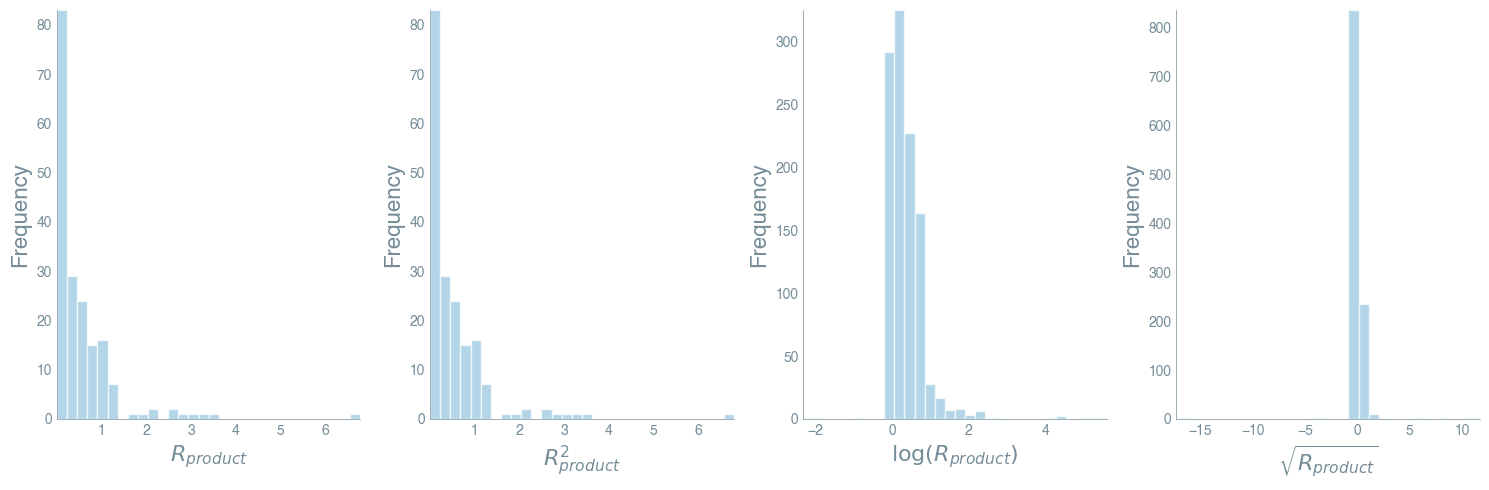

In [24]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer


def power_transform(column):
    pt = PowerTransformer(method='yeo-johnson')
    transformed = pt.fit_transform(column.values.reshape(-1, 1))
    return transformed.flatten()

def preprocess_data_with_transformations(df):
    # Transform r1r2 values
    df['r1r2_sqrt'] = np.sqrt(df['r1r2'])
    df['r1r2_log'] = np.log1p(df['r1r2'])
    df_filtered['r1r2_power'] = power_transform(df['r1r2'])
    
    return df

def calculate_r_product(df):
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']
    return df

df_filtered = calculate_r_product(df_filtered)
df_transformed = preprocess_data_with_transformations(df_filtered)

def train_and_evaluate(df, target_column, alpha=100.0, n_repeats=10):
    all_train_mse = []
    all_test_mse = []
    all_train_r2 = []
    all_test_r2 = []

    for _ in range(n_repeats):
        train_fingerprints_only, test_fingerprints_only, train_all_features, test_all_features, train_regression_labels, test_regression_labels = preprocess_data(df, target_column)

        ridge_model = Ridge(alpha=alpha, solver='saga')
        ridge_model.fit(train_all_features, train_regression_labels)

        train_predictions = ridge_model.predict(train_all_features)
        test_predictions = ridge_model.predict(test_all_features)

        train_mse = mean_squared_error(train_regression_labels, train_predictions)
        test_mse = mean_squared_error(test_regression_labels, test_predictions)
        train_r2 = r2_score(train_regression_labels, train_predictions)
        test_r2 = r2_score(test_regression_labels, test_predictions)

        all_train_mse.append(train_mse)
        all_test_mse.append(test_mse)
        all_train_r2.append(train_r2)
        all_test_r2.append(test_r2)

    avg_train_mse = np.mean(all_train_mse)
    avg_test_mse = np.mean(all_test_mse)
    avg_train_r2 = np.mean(all_train_r2)
    avg_test_r2 = np.mean(all_test_r2)

    print(f'Target: {target_column}')
    print(f'Average Training MSE: {avg_train_mse:.4f}, Average Training R2: {avg_train_r2:.4f}')
    print(f'Average Test MSE: {avg_test_mse:.4f}, Average Test R2: {avg_test_r2:.4f}')



def plot_target_distributions(df):
    # Verwende hier die tatsächlichen Spaltennamen im DataFrame
    actual_columns = ['r-product', 'r-product', 'r1r2_log', 'r1r2_power']
    # LaTeX-Beschriftungen für die Diagramme
    target_labels = [r'$R_{product}$', r'$R_{product}^2$', r'$\log(R_{product})$', r'$\sqrt{R_{product}}$']
    
    plt.style.use('../plots_and_figures/lamalab.mplstyle')
    
    plt.figure(figsize=(15, 5))

    for i, (column, label) in enumerate(zip(actual_columns, target_labels), 1):
        plt.subplot(1, 4, i)
        plt.hist(df[column], bins=30, color='#92C4DE', alpha=0.7)
        plt.xlabel(label, fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        
        plt.grid(False)
        plt.tight_layout()
        plt.gca().set_facecolor('white')
        plt.gcf().set_facecolor('white')

    plt.tight_layout()
    
    plt.savefig('transfomed_data.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Verwende die tatsächlichen Daten hier
plot_target_distributions(df_filtered)

# Train and evaluate for different transformations
#train_and_evaluate(df_transformed, 'r1r2')
#train_and_evaluate(df_transformed, 'r1r2_sqrt')
#train_and_evaluate(df_transformed, 'r1r2_log')
#train_and_evaluate(df_filtered, 'r1r2_power')

In [ ]:
# Preprocess data for Model 1 & 2 (unfiltered data)
train_fingerprints_only_full, test_fingerprints_only_full, train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, train_labels_class2_full, test_labels_class2_full = preprocess_data(df_full)

# Preprocess data for Model 3 (filtered data)
train_fingerprints_only_filtered, test_fingerprints_only_filtered, train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, train_labels_class2_filtered, test_labels_class2_filtered = preprocess_data(df_filtered)

print(len(train_fingerprints_only_full), len(test_fingerprints_only_full))
print(len(train_fingerprints_only_filtered), len(test_fingerprints_only_filtered))
print(len(train_all_features_filtered), len(test_all_features_filtered))

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Function to train and evaluate a model
def train_and_evaluate_model(train_features, test_features, train_labels, test_labels, title):
    model = HistGradientBoostingClassifier(max_iter=500, class_weight={0:1, 1:50})
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)

    # Evaluate Model
    cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=predictions)
    print(cm)
    
    # Calculate Kappa score
    kappa = cohen_kappa_score(test_labels, predictions)
    print(f"Kappa: {kappa:.3f}")
    
    # Plot confusion matrix
    sns.heatmap(pd.DataFrame(cm.normalized_matrix), annot=True,  cbar=False)
    plt.title(f"{title}\nKappa = {kappa:.3}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
# Model 1a: Training with only the fingerprints of the monomers (full data) for Class 1
#train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class1_full, test_labels_class1_full, "Model 1a: Only Fingerprints (No homopolymerization)")

# Model 1b: Training with only the fingerprints of the monomers (full data) for Class 2
#train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class2_full, test_labels_class2_full, "Model 1b: Only Fingerprints (Only homopolymerization)")

In [ ]:
# Model 2a: Training with all parameters (full data) for Class 1
#train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, "Model 2a: All Parameters (No homopolymerization)")

# Model 2b: Training with all parameters (full data) for Class 2
#train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class2_full, test_labels_class2_full, "Model 2b: All Parameters (Only homopolymerization)")

In [ ]:
# Model 3a: Training with filtered data (all parameters) for Class 1
#train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, "Model 3a: All Parameters Filtered (No homopolymerization)")

# Model 3b: Training with filtered data (all parameters) for Class 2
#train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class2_filtered, test_labels_class2_filtered, "Model 3b: All Parameters Filtered (Only homopolymerization)")

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import cohen_kappa_score, confusion_matrix, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.backends.backend_pdf

# Function to load data from a JSON file
def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Custom scoring function for Cohen's kappa
kappa_scorer = make_scorer(cohen_kappa_score)

# Function to train and evaluate a model and plot confusion matrix in a given subplot
def train_and_evaluate_model(train_features, test_features, train_labels, test_labels, title, ax):
    # Define the parameter grid for RandomizedSearchCV
    param_distributions = {
        'max_iter': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_leaf_nodes': [15, 31, 63],
        'min_samples_leaf': [10, 20, 30],
        'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}]
    }
    
    # Define the base model
    base_model = HistGradientBoostingClassifier(random_state=42)
    
    # Perform RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=50,  # Number of parameter settings sampled
        scoring=kappa_scorer,  # Evaluation metric
        cv=3,  # Number of folds in cross-validation
        random_state=42,
        n_jobs=-1  # Use all available CPUs
    )
    
    #search.fit(train_features, train_labels)
    
    # Best model
    #best_model = search.best_estimator_
    #print(f"Best hyperparameters for {title}: {search.best_params_}")
    
    #predictions = best_model.predict(test_features)
    
    model = HistGradientBoostingClassifier(max_iter=500, class_weight={0:1, 1:50})
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    
    # Convert numeric labels to string labels
    test_labels_str = ['False' if label == 1 else 'True' for label in test_labels]
    predictions_str = ['False' if label == 1 else 'True' for label in predictions]

    # Evaluate Model
    cm = confusion_matrix(test_labels_str, predictions_str, labels=['True', 'False'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Calculate Kappa score
    kappa = cohen_kappa_score(test_labels_str, predictions_str, labels=['True', 'False'])
    print(f"Kappa: {kappa:.3f}")

    # Plot confusion matrix
    sns.heatmap(pd.DataFrame(cm_normalized, index=['True', 'False'], columns=['True', 'False']), annot=True, cbar=False, ax=ax, square=True, cmap="PuBu")
    ax.set_title(f"{title}\nKappa = {kappa:.3}")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

# Apply custom style
#plt.style.use('Zustrom_color.mplstyle')

# Create a PDF to save the plots
pdf = matplotlib.backends.backend_pdf.PdfPages("combined_plots.pdf")

# Create a figure with multiple subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Call the function for each model and plot in the corresponding subplot
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class1_full, test_labels_class1_full, "Model 1a: Only Fingerprints (No homopolymerization)", axs[0, 0])
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, "Model 2a: All Parameters (No homopolymerization)", axs[0, 1])
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, "Model 3a: All Parameters Filtered (No homopolymerization)", axs[0, 2])
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class2_full, test_labels_class2_full, "Model 1b: Only Fingerprints (Only homopolymerization)", axs[1, 0])
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class2_full, test_labels_class2_full, "Model 2b: All Parameters (Only homopolymerization)", axs[1, 1])
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class2_filtered, test_labels_class2_filtered, "Model 3b: All Parameters Filtered (Only homopolymerization)", axs[1, 2])

# Adjust layout with more space between subplots
plt.tight_layout(pad=4.0)

# Save the figure to the PDF
pdf.savefig(fig)

# Close the PDF
pdf.close()

# Show the combined plot
plt.show()